In [1]:
%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2
%aimport -sys
%aimport -rpy2
%aimport -pandas
%aimport -numpy

In [2]:
import sys

if '..' not in sys.path:
    sys.path.insert(0, '..')

import glm
import r_plotter
from pandas import DataFrame
from numpy import ndarray
import pandas as pd
import numpy as np

In [3]:
# results['model'].get_prediction(results['input_matrix']).summary_frame()

# Using R in Notebook

## R Function Import

In [5]:
from rpy2 import robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.robjects.vectors import DataFrame as r_DataFrame

#RESOURCES
# 1. https://stackoverflow.com/questions/11238472/how-to-get-rid-code-when-printing-summary-in-rpy2

# 2. how to sub-select columns in R
# mtcars[, -which(names(mtcars) == "carb")]  #only works on a single column
# mtcars[, names(mtcars) != "carb"]          #only works on a single column
# mtcars[, !names(mtcars) %in% c("carb", "mpg")] 
# mtcars[, -match(c("carb", "mpg"), names(mtcars))] 
# mtcars2 <- mtcars; mtcars2$hp <- NULL         #lost column (risky)

# 3. https://www.learnbymarketing.com/tutorials/explaining-the-lm-summary-in-r/

## Passing Data Between Python and R

In [6]:
# def create_df(save: bool = True) -> DataFrame:
#     X: ndarray = results['input_matrix']
#     y: ndarray = results['true_y'].reshape(-1, 1)

#     py_df: DataFrame = \
#         pd.DataFrame(
#             data=np.concatenate((X, y), axis=1), 
#             columns=[*[f'feat_{i+1}' for i in range(10)], 'y'])
    
#     if save:
#         py_df.to_parquet('data.parquet', index = False)

#     return py_df

# py_df = create_df(save=True)

# py_df.head()


In [45]:
#import R functionality
r_arrow = importr('arrow')
r_mass = importr('MASS')

r = robjects.r
r_lm = r['lm']
r_predict = r['predict']
r_summary = r['summary']
r_fitted = r['fitted']
r_resid = r['resid']
r_plot = r['plot']
r_png = r['png']
r_qqnorm = r['qqnorm']
r_lm_influence = r['lm.influence']
r_loess_smooth = r['loess.smooth']

In [8]:
#create dataframe
r_df = r_arrow.read_parquet('data.parquet')

#create R formula
target = 'y'
predictors = r_df.colnames[:-1]
linear_predictor = '+'.join(predictors)
formula = robjects.Formula(f'{target} ~ 0 + {linear_predictor}')

#Fit a linear model.
for i, name in enumerate(list(predictors) + [target]):
    formula.environment[name] = r_df[i] #integer index accesses the column vectors

# #create Python object from R's lm()
model = r_lm(formula=formula)

summary = r_summary(model)

In [9]:
print('Adj. R Sq. = ', summary[8])
print(summary[3])
print('\n')

Adj. R Sq. =  [1] 0.9970769

         Estimate  Std. Error    t value Pr(>|t|)
feat_1  76.891327 0.005769543 13327.1095        0
feat_2  64.095866 0.005770106 11108.2652        0
feat_3  28.466851 0.005768428  4934.9411        0
feat_4  20.752745 0.005764482  3600.1055        0
feat_5  59.801874 0.005767170 10369.3621        0
feat_6  26.094388 0.005772577  4520.4054        0
feat_7   4.603065 0.005772580   797.4017        0
feat_8  78.898106 0.005772353 13668.2740        0
feat_9  88.582059 0.005775952 15336.3558        0
feat_10 67.101503 0.005767612 11634.1910        0





In [46]:
#values for residual diagnostics
fitted = r_fitted(model)

residuals = r_resid(model)

standardized_residuals = r_mass.stdres(model)

qqnorm = r(r'''
    function(x) {
        qqnorm(x, plot.it = F)$x
    }
''')
residuals_quantiles = qqnorm(residuals)

leverage = r_lm_influence(model).rx2('hat')

loess_1 = r_loess_smooth(fitted, residuals)
# loess_2 = loess.smooth(Fitted.Values, Root.Residuals)
# loess_3 = loess.smooth(Leverage, Residuals)

In [9]:
def r_assign(**kwargs) -> None:
    for arg, val in kwargs.items():
        robjects.r.assign(arg, val)
    
    return None

r_assign(model=model)

In [11]:
#plot feat_1
hist = r['hist']
r['png']('./hist.png', width=500, height=500)
hist(r_df[1], main="", xlab="", br=20)
r['dev.off']()

1


In [8]:
print('R model Object')
print(r_model.names)
print('Coefficients')
r_model.rx2('coefficients')

# for i, name in enumerate([target] + predictors):
#     formula.environment[name] = r_df[i+1] #integer index accesses the column vectors

R model Object
 [1] "coefficients"  "residuals"     "effects"       "rank"         
 [5] "fitted.values" "assign"        "qr"            "df.residual"  
 [9] "xlevels"       "call"          "terms"         "model"        

Coefficients


76.891327,64.095866,28.466851,...,78.898106,88.582059,67.101503


In [9]:
def r_assign(**kwargs) -> None:
    for arg, val in kwargs.items():
        robjects.r.assign(arg, val)
    
    return None

r_assign(model=r_model)
# %R summary(r_model) #does not work and I do not know why

In [10]:
model = r['model']
# summary = r['summary']
predict = r['predict']

predict(model)

512.828440,-48.809201,91.920286,...,97.358337,78.950054,241.594966


In [9]:
%%R
library(arrow)

df = arrow::read_parquet('data.parquet')
predictors = names(df[, names(df) != 'y'])
formula = paste('y~', paste(predictors, collapse='+'))
model = lm(formula, df)

summary(model)
# plot(model)


Call:
lm(formula = formula, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-50.561  -6.740   0.009   6.737  48.925 

Coefficients:
             Estimate Std. Error  t value Pr(>|t|)    
(Intercept) 2.315e-04  5.770e-03     0.04    0.968    
feat_1      7.689e+01  5.770e-03 13327.11   <2e-16 ***
feat_2      6.410e+01  5.770e-03 11108.26   <2e-16 ***
feat_3      2.847e+01  5.768e-03  4934.94   <2e-16 ***
feat_4      2.075e+01  5.764e-03  3600.10   <2e-16 ***
feat_5      5.980e+01  5.767e-03 10369.36   <2e-16 ***
feat_6      2.609e+01  5.773e-03  4520.40   <2e-16 ***
feat_7      4.603e+00  5.773e-03   797.40   <2e-16 ***
feat_8      7.890e+01  5.772e-03 13668.27   <2e-16 ***
feat_9      8.858e+01  5.776e-03 15336.35   <2e-16 ***
feat_10     6.710e+01  5.768e-03 11634.19   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 9.994 on 2999989 degrees of freedom
Multiple R-squared:  0.9971,	Adjusted R-squared:  0.9971 
F-st

In [99]:
robjects.r.assign('val', val)
robjects.r.assign('exp', exp)
robjects.r.assign('tiempo', tiempo)
robjects.r('anova <- aov(val ~ tiempo + exp)')
robjects.r('s.anova <- summary(anova)')
robjects.r('spHoc <- summary(glht(anova, linfct=mcp(tiempo="Dunnet")))')
print robjects.r('s.anova')
print ro.r('spHoc')
ro.r('capture.output(s.anova, file = "anova.txt", append = TRUE)')
ro.r('capture.output(spHoc, file = "anova.txt", append = TRUE)')


In [14]:
def r_assign(**kwargs) -> None:
    for arg, val in kwargs.items():
        robjects.r.assign(arg, val)
    
    return None

%R library(arrow)
%R r_df = arrow::read_parquet('data.parquet')

columns = pd.read_parquet('data.parquet').columns
target = columns[-1]
predictors = columns[:-1].values
linear_predictor = '+'.join(predictors)
formula = f'{target} ~ 0 + {linear_predictor}'

print(formula)
# robjects.r('model = lm(formula)')
# robjects.r('s.anova <- summary(anova)')

y ~ 0 + feat_1+feat_2+feat_3+feat_4+feat_5+feat_6+feat_7+feat_8+feat_9+feat_10


In [18]:
r_assign(predictors=predictors)

NotImplementedError: Conversion 'py2rpy' not defined for objects of type '<class 'numpy.ndarray'>'

In [16]:
r_assign(target=target, predictors=predictors, formula=formula)

NotImplementedError: Conversion 'py2rpy' not defined for objects of type '<class 'numpy.ndarray'>'

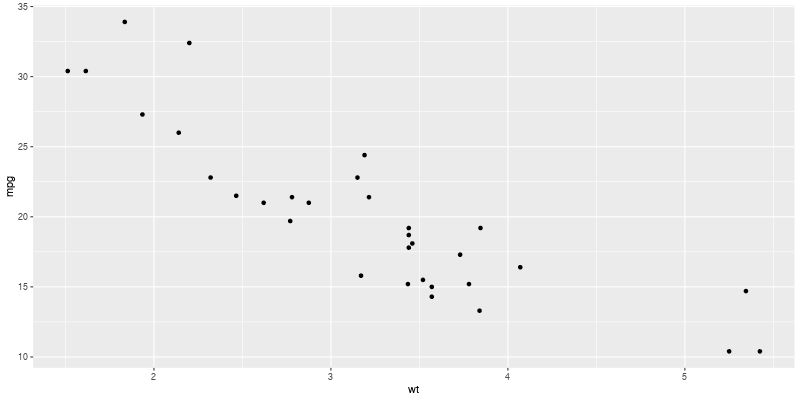

In [101]:
import math, datetime
import rpy2.robjects.lib.ggplot2 as ggplot2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.ipython.ggplot import image_png

base = importr('base')

mtcars = data(datasets).fetch('mtcars')['mtcars']

rnorm = stats.rnorm
dataf_rnorm = \
    robjects.DataFrame({
        'value': rnorm(300, mean=0) + rnorm(100, mean=3),
        'other_value': rnorm(300, mean=0) + rnorm(100, mean=3),
        'mean': IntVector([0, ]*300 + [3, ] * 100)})
gp = ggplot2.ggplot(mtcars)

pp = (gp +
      ggplot2.aes_string(x='wt', y='mpg') +
      ggplot2.geom_point())

image_png(pp)

In [106]:
dataf = r_utils.read_csv('https://raw.githubusercontent.com/jakevdp/PythonDataScienceHandbook/'
                       'master/notebooks/data/california_cities.csv')

import rpy2.ipython.html
rpy2.ipython.html.init_printing()

dataf

,,X,city,latd,longd,...,area_water_km2,area_water_percent
0,1,0,Adelanto,34.57611111111112,-117.43277777777779,...,0.046,0.03
1,2,1,AgouraHills,34.15333333333333,-118.76166666666667,...,0.076,0.37
2,3,2,Alameda,37.75611111111111,-122.27444444444444,...,31.983,53.79
3,4,3,Albany,37.886944444444445,-122.29777777777778,...,9.524,67.28
4,5,4,Alhambra,34.081944444444446,-118.135,...,0.003,0.01
5,6,5,AlisoViejo,33.575,-117.72555555555556,...,0.0,0.0
6,7,6,Alturas,41.48722222222222,-120.5425,...,0.036000000000000004,0.57
7,8,7,AmadorCity,38.419444444444444,-120.82416666666666,...,0.0,0.0
...,...,...,...,...,...,...,...,...
480,481,480,Yucaipa,34.030277777777776,-117.04861111111111,...,0.013000000000000001,0.02


In [105]:
stats = importr('stats')
base = importr('base')
fit = stats.lm('elevation_m ~ latd + longd', data=dataf)
fit

0,coefficients,(Intercep...
1,residuals,...
2,effects,...
3,rank,[1] 3
4,fitted.values,...
5,assign,[1] 0 1 2
6,qr,$qr ...
7,df.residual,[1] 431
...,...,...
11,terms,elevation...
12,model,...


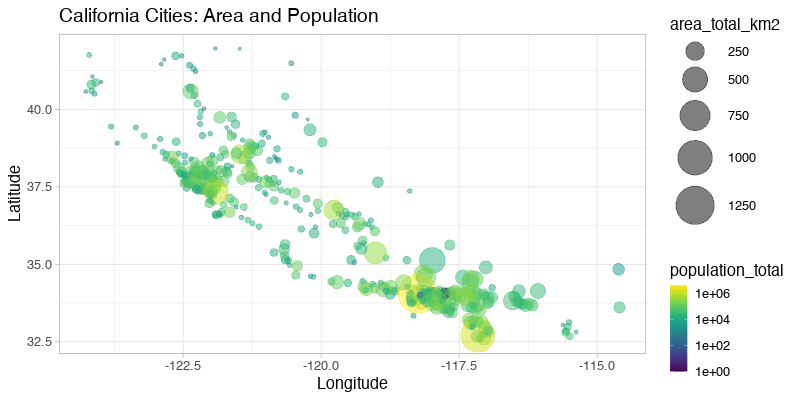

In [112]:
import rpy2.robjects.lib.ggplot2 as gp

viridis = importr('viridis')
class ScaleColorViridis(gp.ScaleColour):
    _constructor = viridis.scale_color_viridis
scale_color_viridis = ScaleColorViridis.new

p = (gp.ggplot(dataf) +
     gp.aes(x=rl('longd'),
            y=rl('latd'),
            color=rl('population_total'),
            size=rl('area_total_km2')) +
     gp.geom_point(alpha=0.5) +
     gp.scale_x_continuous('Longitude') +
     gp.scale_y_continuous('Latitude') +
     gp.scale_size(range=IntVector([1, 18])) +
     scale_color_viridis(trans='log10') +
     gp.ggtitle('California Cities: Area and Population') +
     gp.theme_light(base_size=16))
image_png(p)